# Intrdouction

We perform semantic segmentation using MobileNetV3_UNet Architecture

## Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from glob import glob
import os
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms,models
from dataclasses import dataclass


In [2]:
# install libraries
!pip install torchinfo -q
from torchinfo import summary

In [3]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## Explore data and labels

In [4]:
# Read csv
df = pd.read_csv('/kaggle/input/semantic-drone-dataset/class_dict_seg.csv')
df

name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0

In [5]:
# put all labels in a class
class_list = df.name.values.tolist()
print(class_list)

['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']


In [6]:
# Check if images and labels match
rgb_images = os.listdir('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images')
mask_images = os.listdir('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic')

print(rgb_images[:4])
print('number of images',len(rgb_images),'number of masks',len(mask_images))

rgb_images.sort()
mask_images.sort()

# Check that masks and images are sorted
print('rgb images',rgb_images[:4])
print('masks',mask_images[:4])

['208.jpg', '473.jpg', '014.jpg', '537.jpg']
number of images 400 number of masks 400
rgb images ['000.jpg', '001.jpg', '002.jpg', '003.jpg']
masks ['000.png', '001.png', '002.png', '003.png']


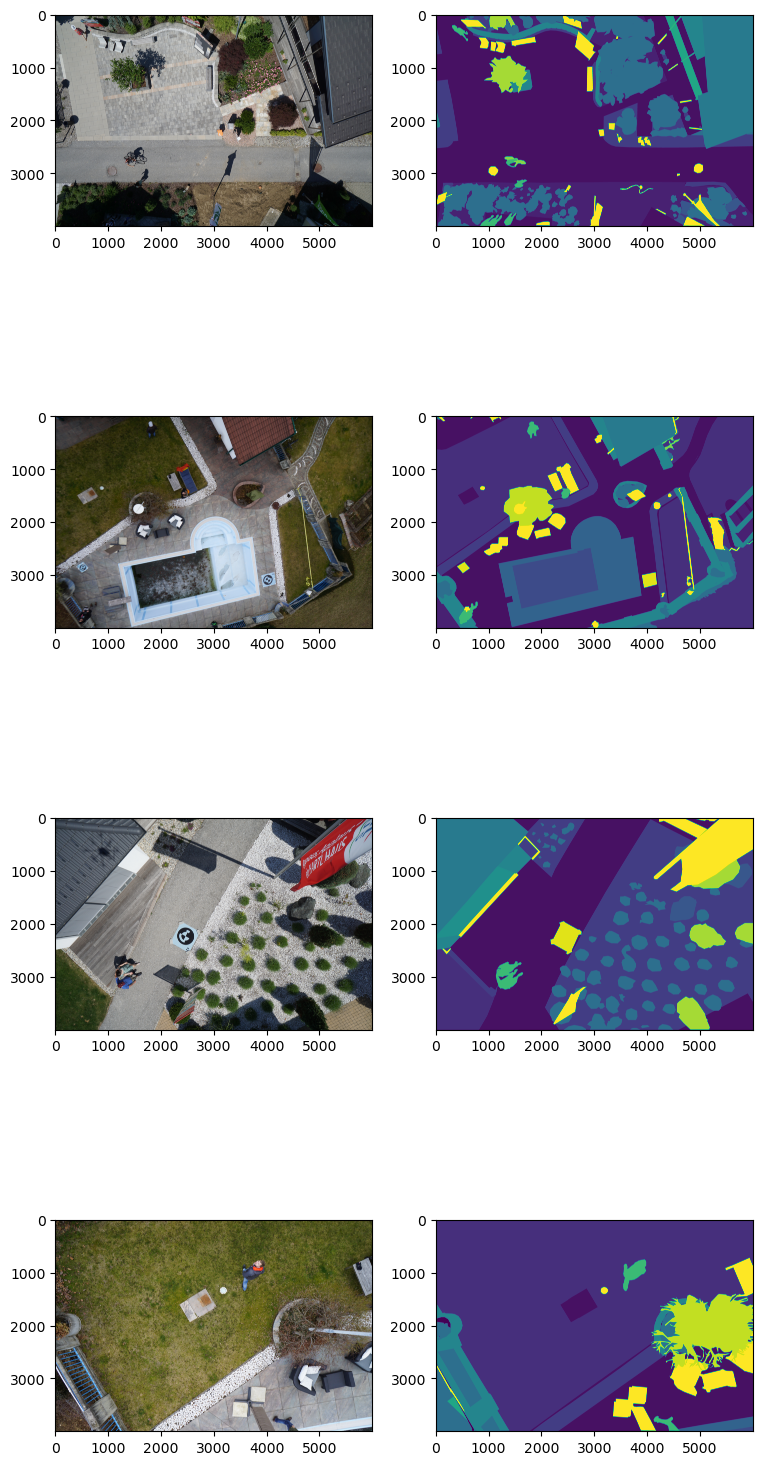

In [7]:
#Preview images and their respective labels
plt.figure(figsize = (9, 20))

np.random.seed(71)
rand_imgs = np.random.choice(rgb_images,size=4)

rand_imgs_no = [i[:-4] for i in rand_imgs]

for i,j in enumerate(rand_imgs_no):
    image = PIL.Image.open(f'/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/{rand_imgs_no[i]}.jpg')
    image = np.array(image)

    label = PIL.Image.open(f'/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/{rand_imgs_no[i]}.png')
    label = np.array(label)
        
    plt.subplot(4,2, 2* i + 1)
    plt.imshow(image)

    plt.subplot(4,2,2* i + 2)
    plt.imshow(label)

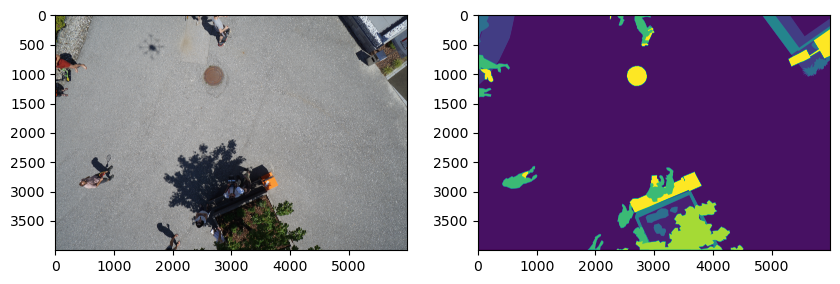

In [8]:
# RGB image
image = PIL.Image.open('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg')
image = np.array(image)

# Mask(label) image
label = PIL.Image.open('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png')
label = np.array(label)

plt.figure(figsize = (10, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(label);

In [9]:
# Check dimensions, min and max values of both the rgb image and mask
print('image shape',image.shape,'label shape',label.shape)
print('image min value',image.min(), '\nimage max value',image.max())
print('label min value',label.min(), '\nlabel max value',label.max())

image shape (4000, 6000, 3) label shape (4000, 6000)
image min value 0 
image max value 255
label min value 0 
label max value 22


From the above we can see we would need to normalize both the rgb images and their corresponding masks. Also we need to resize them.

## Let's create our training, test and validation set

In [10]:
# Split data in array into train test and validation sets

def split_data(images ,seed=42):
    split_size_train = 0.6
    split_size_test= 0.8

    np.random.seed(seed)
    np.random.shuffle(images)
    
    train_imgs = images[:int(len(images)*split_size_train)]
    test_imgs = images[int(len(images)*split_size_train):int(len(images)*split_size_test)]
    val_imgs  = images[int(len(images)*split_size_test):]
    
    print(len(train_imgs),len(test_imgs),len(val_imgs))
    #Result sample
    print(train_imgs[:4])
    return train_imgs,test_imgs,val_imgs
#remove file extension(.jpg)
image_no = [i[:-4] for i in rgb_images]
train_imgs,test_imgs,val_imgs = split_data(image_no, 42)

240 80 80
['305', '423', '053', '306']


In [11]:
# Opencv Augmentation Pipeline
def horizontal_flip(img, flag=True):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img
def vertical_flip(img, flag=True):
    if flag:
        return cv2.flip(img, 0)
    else:
        return img
def rotation(img, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h),borderMode=cv2.BORDER_REFLECT)
    return img

## Preview augmentation

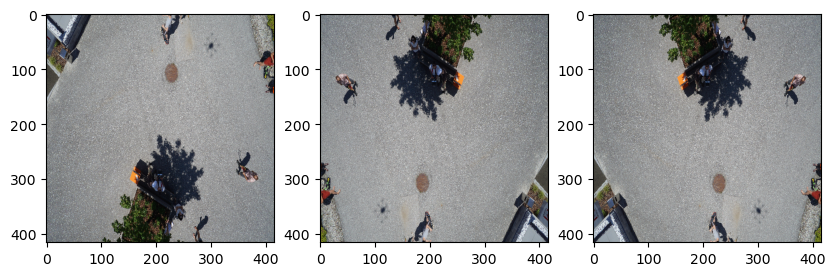

In [12]:
plt.figure(figsize = (10, 6))

for i in train_imgs:
    img = cv2.imread('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg')
    # convert BGR to RGB
    img = img[...,::-1]
    img_resized = cv2.resize(img, dsize = (416, 416))
    img = horizontal_flip(img_resized)
    plt.subplot(131)
    plt.imshow(img)
    img = vertical_flip(img_resized)
    plt.subplot(132)
    plt.imshow(img)
    for i_ang in range(0,200,20):
        img = rotation(img_resized,angle=i_ang)
        plt.subplot(133)
        plt.imshow(img)
    break

In [13]:
# Create folders for images and labels
os.makedirs('/kaggle/working/data/train_aug/images')
os.makedirs('/kaggle/working/data/train_aug/labels')
os.makedirs('/kaggle/working/data/test/images')
os.makedirs('/kaggle/working/data/test/labels')
os.makedirs('/kaggle/working/data/val/images')
os.makedirs('/kaggle/working/data/val/labels')

In [14]:
# We have only 400 images which is really small hence we would
# 1. Resize all images to 300x300
# 2. Split the data into 60,20,20
# 3. The train set would be augmented from 240 images and their corresponding masks to say 3000 .
# 4. Test and validation set would not be augmented

In [15]:

imgs_path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
labels_path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

for i in train_imgs:
    img = cv2.imread(imgs_path+i+'.jpg')
    label_img = cv2.imread(labels_path+i+'.png',cv2.IMREAD_UNCHANGED)
    # convert BGR to RGB
    img = img[...,::-1]
    img_resized = cv2.resize(img, dsize = (416, 416))
    cv2.imwrite(f"/kaggle/working/data/train_aug/images/{i}.jpg",img_resized)
    img = horizontal_flip(img_resized)
    cv2.imwrite(f"/kaggle/working/data/train_aug/images/{i}_horiz_flip.jpg",img)
    img = vertical_flip(img_resized)
    cv2.imwrite(f"/kaggle/working/data/train_aug/images/{i}_vert_flip.jpg",img)

    label_img_resized = cv2.resize(label_img, dsize = (416, 416))
    cv2.imwrite(f"/kaggle/working/data/train_aug/labels/{i}.png",label_img_resized)
    label_img = horizontal_flip(label_img_resized)
    cv2.imwrite(f"/kaggle/working/data/train_aug/labels/{i}_horiz_flip.png",label_img)
    label_img = vertical_flip(label_img_resized)
    cv2.imwrite(f"/kaggle/working/data/train_aug/labels/{i}_vert_flip.png",label_img)
    for i_ang in range(0,200,20):
        img_rot = rotation(img_resized,angle=i_ang)
        cv2.imwrite(f"/kaggle/working/data/train_aug/images/{i}_{i_ang}.jpg",img_rot)    

        label_img_rot = rotation(label_img_resized,angle=i_ang)
        cv2.imwrite(f"/kaggle/working/data/train_aug/labels/{i}_{i_ang}.png",label_img_rot)    

In [16]:
aug_img_path_list = sorted(glob('/kaggle/working/data/train_aug/images/*.jpg'))
print(len(aug_img_path_list))

aug_lbl_path_list = sorted(glob('/kaggle/working/data/train_aug/labels/*.png'))
print(len(aug_lbl_path_list))

3120
3120


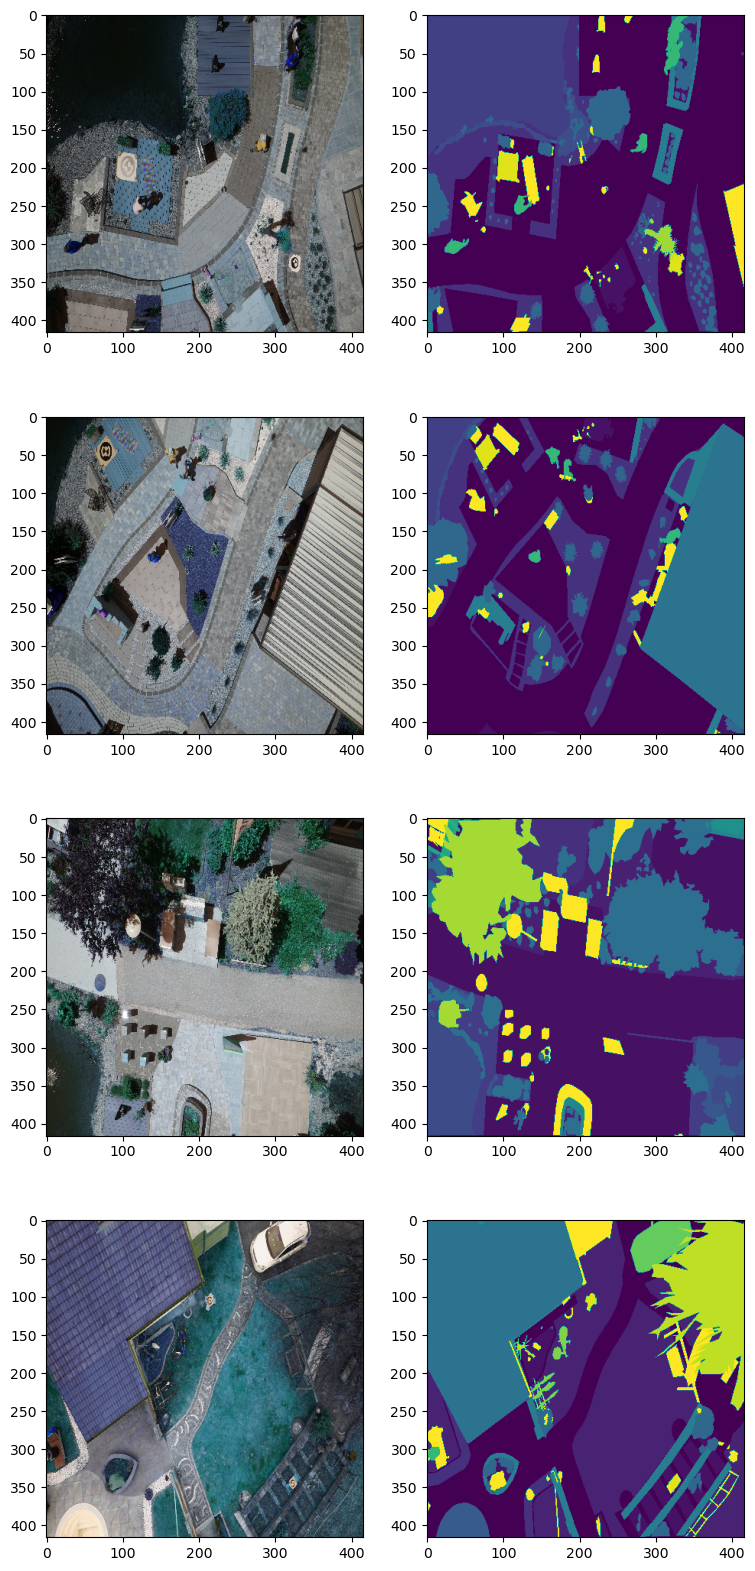

In [17]:
# Preview saved augmented images
plt.figure(figsize = (9, 20))

for i,j in enumerate(train_imgs):
    image = PIL.Image.open(f'/kaggle/working/data/train_aug/images/{train_imgs[i]}.jpg')
    image = np.array(image)

    label = PIL.Image.open(f'/kaggle/working/data/train_aug/labels/{train_imgs[i]}.png')
    label = np.array(label)
        
    plt.subplot(4,2, 2* i + 1)
    plt.imshow(image)

    plt.subplot(4,2,2* i + 2)
    plt.imshow(label)
    if  i ==3:
        break

In [18]:
# resize and save images for test and validation

# save test and validation images
imgs_path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
labels_path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

def resized_save(dataset='test'):
    for i in eval(f'{dataset}_imgs'):
        img = cv2.imread(imgs_path+i+'.jpg')
        # convert BGR to RGB
        img = img[...,::-1]
        labels_img = cv2.imread(labels_path+i+'.png',cv2.IMREAD_UNCHANGED)

        img_resized = cv2.resize(img, dsize = (416, 416))
        labels_img_resized = cv2.resize(labels_img, dsize = (416, 416))

        cv2.imwrite(f"/kaggle/working/data/{dataset}/images/{i}.jpg",img_resized)    
        cv2.imwrite(f"/kaggle/working/data/{dataset}/labels/{i}.png",labels_img_resized)
        
    print(len(sorted(glob(f'/kaggle/working/data/{dataset}/labels/*.png'))),f'added to {dataset} folder')
resized_save()
resized_save('val')

80 added to test folder
80 added to val folder


In [19]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor


class SegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.imgpath_list = image_dir
        self.labelpath_list = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.imgpath_list)
    def __getitem__(self, i):
        
        imgpath = self.imgpath_list[i]
        img = cv2.imread(imgpath)
        img = img[...,::-1]
        img = img / 255
        img = torch.from_numpy(img.astype(np.float32)).clone()
        img = img.permute(2, 0, 1)

        labelpath = self.labelpath_list[i]
        label = cv2.imread(labelpath,cv2.IMREAD_UNCHANGED)
        label = np.asarray(label)
        label = torch.from_numpy(label.astype(np.float32)).clone()
        label = torch.nn.functional.one_hot(label.long(), num_classes = len(class_list))
        label = label.to(torch.float32)
        label = label.permute(2, 0, 1)
 
        
        data = {"img": img, "label": label}
        return data

In [43]:
## Training configuration
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 4  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 10  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.0001  # determines the speed of network's weights update
    log_interval: int = 50  # how many batches to wait between logging training status
    val_interval: int = 5  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    device: str = 'cuda'  # device to use for training.


In [44]:

# Set the paths to the train and validation image and mask directories
train_image_dir = sorted(glob('/kaggle/working/data/train_aug/images/*.jpg'))
train_mask_dir = sorted(glob('/kaggle/working/data/train_aug/labels/*.png'))
val_image_dir = sorted(glob('/kaggle/working/data/val/images/*.jpg'))
val_mask_dir = sorted(glob('/kaggle/working/data/val/labels/*.png'))

# Define the transforms to be applied to the images
transform = Compose([
    ToTensor(),  # Convert the image and mask to PyTorch tensors
])

# Define the train and validation datasets
train_dataset = SegDataset(image_dir=train_image_dir, mask_dir=train_mask_dir)
val_dataset = SegDataset(image_dir=val_image_dir, mask_dir=val_mask_dir)


batch_size = TrainingConfiguration.batch_size
# drop_last = True drop the last incomplete batch, if the dataset size is not divisible by the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size,drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Model

In [45]:

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2,inplace=True)
    )

def double_up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2,inplace=True),
        nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2,inplace=True)
    )


class MobileNetV3_UNet(nn.Module):
    def __init__(self, out_channels=24):
        super(MobileNetV3_UNet, self).__init__()
        
        # Encoder
        self.mobilenet = models.mobilenet_v3_small(weights=None).features
        self.enc1 = nn.Sequential(self.mobilenet[0:1])
        self.enc2 = nn.Sequential(self.mobilenet[1:2])
        self.enc3 = nn.Sequential(self.mobilenet[2:9])
        self.enc4 = nn.Sequential(self.mobilenet[9:12])
        self.enc5 = nn.Sequential(self.mobilenet[12:])

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2,stride=2)

        # Decoder        
        self.up_conv6 = up_conv(576,96)
        self.up_conv7 = up_conv(192,256)
        self.up_conv8 = double_up_conv(304,128)
        self.up_conv9 = up_conv(144,64)
        self.up_conv_out = up_conv(80,32)
        
        # Output
        self.out = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        
        # Decoder
        x = self.up_conv6(enc5)
        x = self.max_pool_2x2 (x)  
        x = torch.cat([x, enc4], dim=1)

        x = self.up_conv7(x)
        x = torch.cat([x, enc3], dim=1)

        x = self.up_conv8(x)
        x = torch.cat([x, enc2], dim=1)

        x = self.up_conv9(x)
        x = torch.cat([x, enc1], dim=1)

        x = self.up_conv_out(x)

        out = self.out(x)
        
        return out

summary(MobileNetV3_UNet(), input_size=(1, 3, 416, 416), 
        row_settings=["var_names"],
        col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
        col_width=16)


Layer (type (var_name))                                           Kernel Shape     Output Shape     Param #          Mult-Adds
MobileNetV3_UNet (MobileNetV3_UNet)                               --               [1, 24, 416, 416] --               --
├─Sequential (enc1)                                               --               [1, 16, 208, 208] --               --
│    └─Sequential (0)                                             --               [1, 16, 208, 208] --               --
│    │    └─Conv2dNormActivation (0)                              --               [1, 16, 208, 208] 464              18,690,080
├─Sequential (enc2)                                               --               [1, 16, 104, 104] --               --
│    └─Sequential (0)                                             --               [1, 16, 104, 104] --               --
│    │    └─InvertedResidual (1)                                  --               [1, 16, 104, 104] 744              4,326,744
├─Sequentia

## Training and Validation

In [46]:
device = torch.device(TrainingConfiguration.device if torch.cuda.is_available() else "cpu")
unet = MobileNetV3_UNet().to(device)
optimizer = optim.Adam(unet.parameters(), lr = TrainingConfiguration.learning_rate )

In [47]:
!pip install -U segmentation-models-pytorch -q
import segmentation_models_pytorch as smp

In [48]:
# Define loss function
# Combination is a weighted average of Binary crossentropy loss and TverskyLoss
TverskyLoss = smp.losses.TverskyLoss(mode = 'multilabel', log_loss = False)
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()

def criterion(pred,target):
    return 0.5 * BCELoss(pred, target) + 0.5 * TverskyLoss(pred, target)

In [49]:
train = len(train_loader)
val = len(val_loader)

In [50]:
history = {"train_loss": []}
n = 0
m = 0
val_loss_min = np.Inf
validation_accuracy = []
validation_loss = []
validation_iou=[]
for epoch in range(TrainingConfiguration.epochs_count):
    train_accuracy = 0
    train_loss = 0
    val_accuracy = 0
    val_loss = 0
    correct_pixels = 0
    total_pixels = 0

    # training
    unet.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data["img"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        outputs = unet(inputs)

        # pixel accuracy
        thresholded_outputs = (outputs > 0.5).int()
        correct_pixels = (thresholded_outputs == labels).sum().item()
        total_pixels += (inputs.size(2) * inputs.size(3)) * inputs.size(0)
        train_acc = correct_pixels / total_pixels
        train_accuracy += train_acc

        # loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        history["train_loss"].append(loss.item())

        n += 1
        if i % ((train // batch_size) // 10) == (train // batch_size) // 10 -1:
            print(f"epoch:{epoch + 1}  index:{i + 1}  train_accuracy:{train_accuracy / n:.5f}")
            print(f"epoch:{epoch + 1}  index:{i + 1}  train_loss:{train_loss / n:.5f}")
            n = 0
            train_accuracy = 0
            train_loss = 0

    # validation
    unet.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data["img"].to(device), data["label"].to(device)
            outputs = unet(inputs)

            # pixel accuracy
            thresholded_outputs = (outputs > 0.5).int()
            correct_pixels = (thresholded_outputs == labels).sum().item()
            total_pixels += (inputs.size(2) * inputs.size(3)) * inputs.size(0)
            val_acc = correct_pixels / total_pixels
            val_accuracy += val_acc  
            
    
            # loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            m += 1
            if i % (val // batch_size) == val // batch_size - 1:
                print(f"epoch:{epoch + 1}  index:{i + 1}  validation_accuracy:{val_accuracy / m:.5f}")
                print(f"epoch:{epoch + 1}  index:{i + 1}  validation_loss:{val_loss / m:.5f}")
                validation_accuracy.append(val_accuracy)
                validation_loss.append(val_loss)
                validation_iou.append(val_iou)
                if val_loss < val_loss_min:
                    val_loss_min = val_loss
                    torch.save(unet.state_dict(), 'semantic_segmentation.pt')
                    print('Detected network improvement, saving current model')

                m = 0
                val_accuracy = 0
                val_loss = 0
    

print("finish training")

epoch:1  index:19  train_accuracy:3.86452
epoch:1  index:19  train_loss:0.81589
epoch:1  index:38  train_accuracy:0.78454
epoch:1  index:38  train_loss:0.80803
epoch:1  index:57  train_accuracy:0.47102
epoch:1  index:57  train_loss:0.80306
epoch:1  index:76  train_accuracy:0.33769
epoch:1  index:76  train_loss:0.79397
epoch:1  index:95  train_accuracy:0.26254
epoch:1  index:95  train_loss:0.78594
epoch:1  index:114  train_accuracy:0.21513
epoch:1  index:114  train_loss:0.78127
epoch:1  index:133  train_accuracy:0.18178
epoch:1  index:133  train_loss:0.77935
epoch:1  index:152  train_accuracy:0.15801
epoch:1  index:152  train_loss:0.77438
epoch:1  index:171  train_accuracy:0.13976
epoch:1  index:171  train_loss:0.76542
epoch:1  index:190  train_accuracy:0.12532
epoch:1  index:190  train_loss:0.73084
epoch:1  index:209  train_accuracy:0.11368
epoch:1  index:209  train_loss:0.75582
epoch:1  index:228  train_accuracy:0.10390
epoch:1  index:228  train_loss:0.75315
epoch:1  index:247  train_

7800


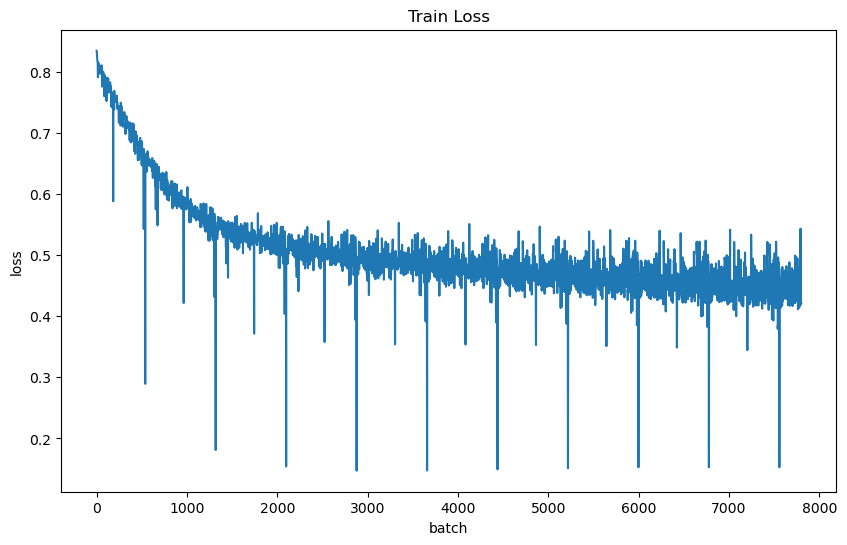

In [55]:


plt.title("Train Loss")
plt.plot(history["train_loss"])
plt.xlabel('batch')
plt.ylabel('loss')

print(len(history['train_loss']))

Text(0, 0.5, 'accuracy')

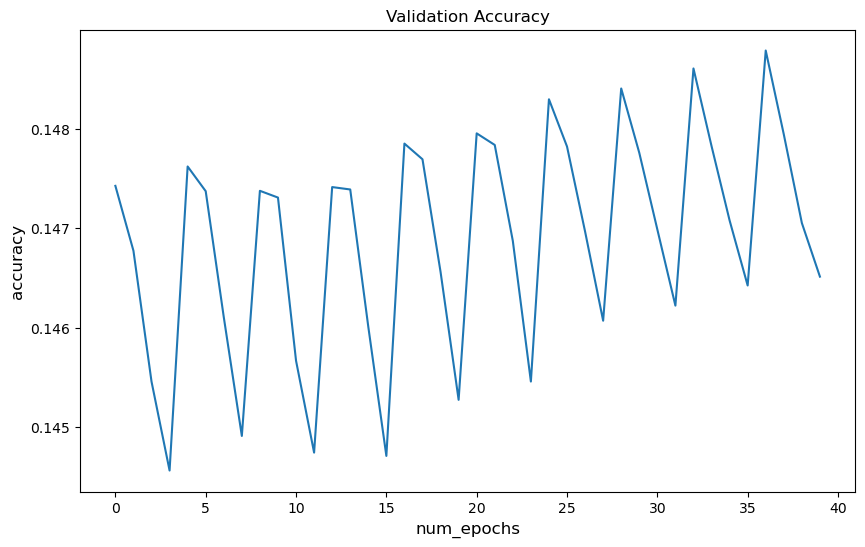

In [56]:
plt.title("Validation Accuracy")
plt.plot(validation_accuracy)
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('accuracy', fontsize = 12)

Text(0, 0.5, 'loss')

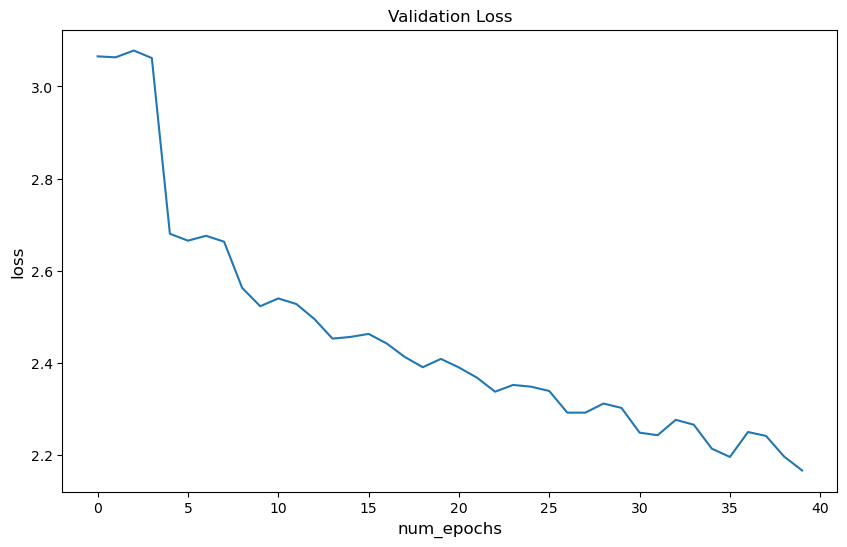

In [57]:
plt.title("Validation Loss")
plt.plot(validation_loss)
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('loss', fontsize = 12)

## Prediction

In [64]:

# Set the paths to the train and validation image and mask directories
test_image_dir = sorted(glob('/kaggle/working/data/test/images/*.jpg'))
test_mask_dir = sorted(glob('/kaggle/working/data/test/labels/*.png'))

# Define the transforms to be applied to the images
transform = Compose([
    ToTensor(),  # Convert the image and mask to PyTorch tensors
])

test_dataset = SegDataset(image_dir=test_image_dir, mask_dir=test_mask_dir)


batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [65]:
model = MobileNetV3_UNet()
model.load_state_dict(torch.load("semantic_segmentation.pt"))
model.eval()
with torch.no_grad():
    data = next(iter(test_loader))
    inputs, labels = data["img"], data["label"]
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    print("Loss: ", loss.item())

    thresholded_outputs = (outputs > 0.5).int()
    intersection = torch.logical_and(thresholded_outputs, labels).sum(dim = [1, 2, 3]).float()
    union = torch.logical_or(thresholded_outputs, labels).sum(dim = [1, 2, 3]).float()
    iou_score = (intersection / union).mean().item()
    print("Intersection over Union:", iou_score)


sigmoid = nn.Sigmoid()
outputs = sigmoid(outputs)
pred = torch.argmax(outputs, axis = 1)
pred = torch.nn.functional.one_hot(pred.long(), num_classes = len(class_list)).to(torch.float32)

Loss:  0.41146886348724365
Intersection over Union: 0.6066415905952454


(-0.5, 415.5, 415.5, -0.5)

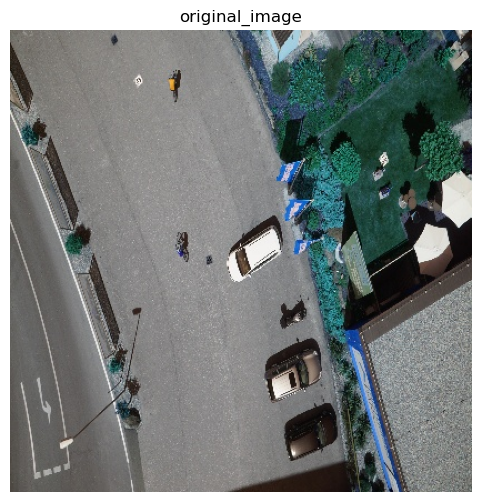

In [66]:
plt.figure()
plt.imshow(data["img"][0, :, :, :].permute(1, 2, 0))
plt.title("original_image")
plt.axis("off")

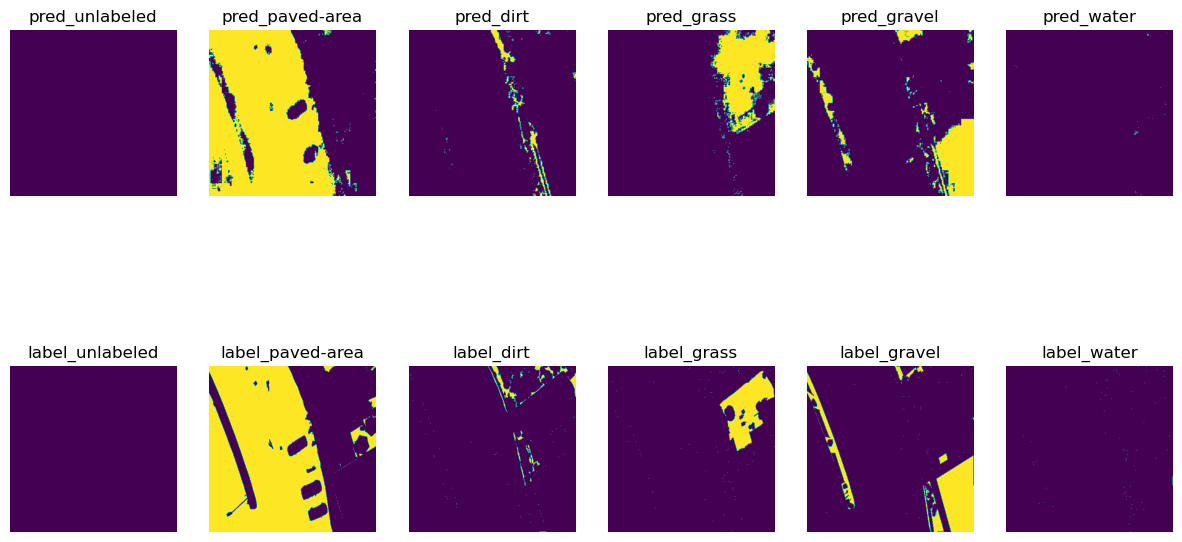

In [67]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for i in range(2):
    for j, cl in enumerate(classes):
        if i == 0 and j < 6:
            ax[i, j].imshow(pred[0, :, :, j])
            ax[i, j].set_title(f"pred_{cl}")
            ax[i, j].axis("off")
        elif j < 6:
            ax[i, j].imshow(data["label"][0, j, :, :])    
            ax[i, j].set_title(f"label_{cl}")
            ax[i, j].axis("off")

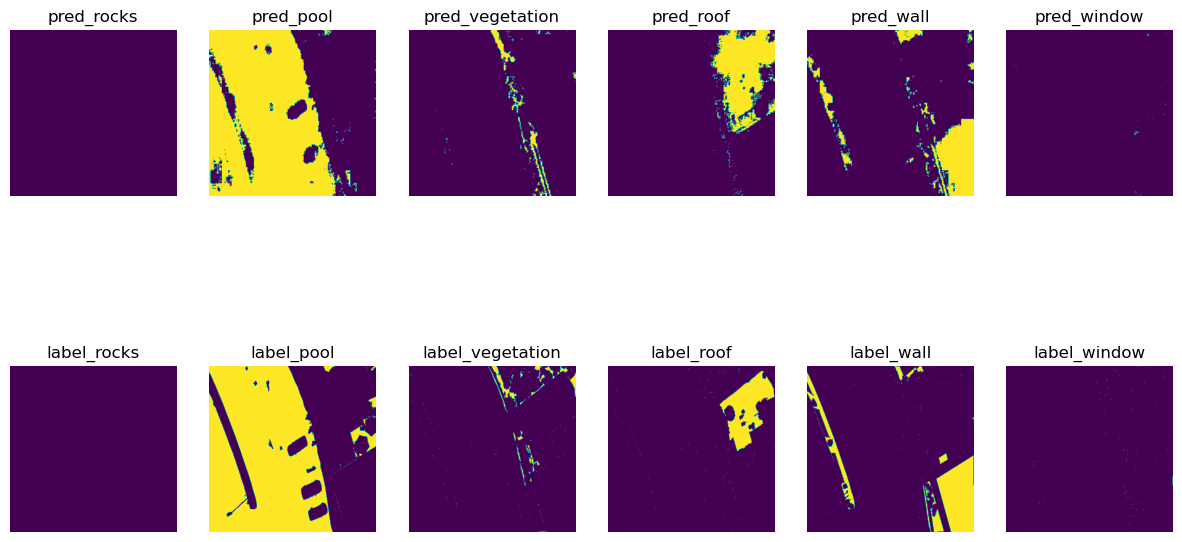

In [68]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for i in range(2):
    for j, cl in enumerate(classes[6:12]):
        if i == 0 and j < 6:
            ax[i, j].imshow(pred[0, :, :, j])
            ax[i, j].set_title(f"pred_{cl}")
            ax[i, j].axis("off")
        elif j < 6:
            ax[i, j].imshow(data["label"][0, j, :, :])    
            ax[i, j].set_title(f"label_{cl}")
            ax[i, j].axis("off")


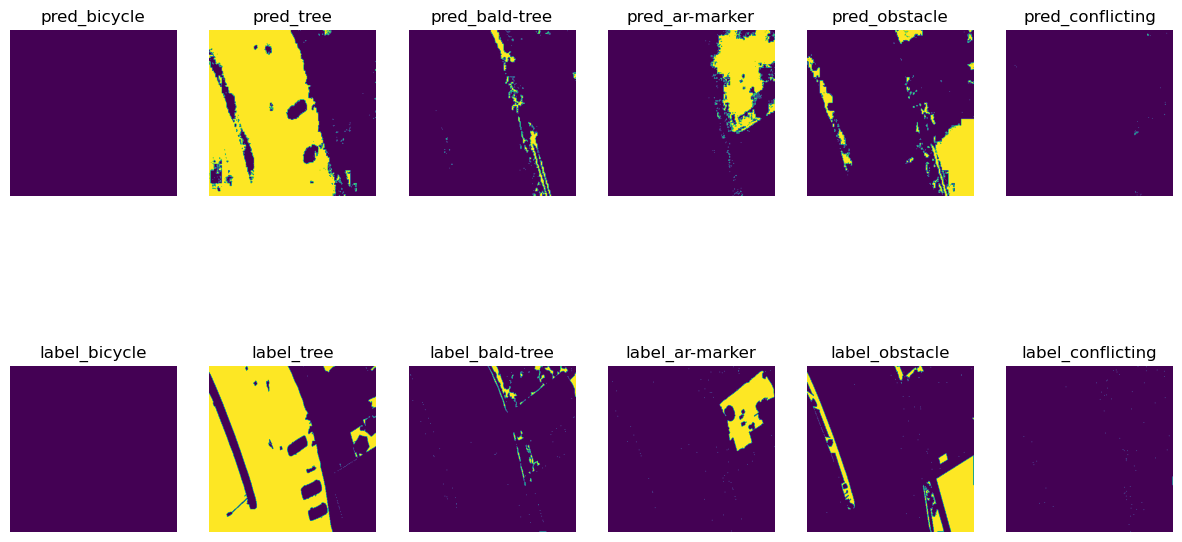

In [69]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for i in range(2):
    for j, cl in enumerate(classes[18:]):
        if i == 0 and j < 6:
            ax[i, j].imshow(pred[0, :, :, j])
            ax[i, j].set_title(f"pred_{cl}")
            ax[i, j].axis("off")
        elif j < 6:
            ax[i, j].imshow(data["label"][0, j, :, :])    
            ax[i, j].set_title(f"label_{cl}")
            ax[i, j].axis("off")
